In [1]:
%matplotlib inline

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.io.wavfile
from scipy.fftpack import fft, fftfreq
from scipy.fftpack import dct
from scipy.signal import get_window

#### INTRODUCTION
 
As we now, especially for machine learning, managable and compressed datasets for research make the proccess easier to implementation, reduce storage space. So for developers, main task is to reduce database with minimal errors without losing any important or relevant data. Nowdays speech recognition or any other type of speech system is very important. 
There are many techniques for keeping signal information while reduce the dimension. Mel-frequency Cepstrum Coefficient is designed to model features of audio signal and is widely used in various fields. 
 
Description From Wikipedia:  
"In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency."
 
#### Steps for implementation:
 
For feature extraction, Mel Frequency Cepstrum Coefficient (MFCC) is capable to extract harmonics and sidebands of the spectrum version of the signal in some period of time. MFCCs are composing the MFC. These coefficients are derived form the type of cepstral representation of the audio clip. MFCCs provide a compact representation of the audio signal that captures the important features related to human hearing. These features can then be used in applications like speech recognition.
 
The difference in MFC is that, as we know humans can hear between some determined frequencies in non-linear way. Mel scale is presenting (convert) actual frequency scale to scale in a way human percieve the sounds. 
 
Sound wave is a wave, which can be presented like series of numbers (samples). Samples "sample rates" are measured in Hz, which we can call Frequency. Spectrum sound is the presentation of all frequancies and amplitudes. Amplitude present how intense is the wave in that time. Power of spectrum is telling how much of different frequincies is present in a sound signal at some time. 
 
Cepstrum is helping to investigate and separate the different components of the sound signal. To get the cepstrum, you compute the logarithm of the power spectrum (to compress the range of values) and then perform a transformation called the Discrete Cosine Transform (DCT). Actually Cepstrum is just Spectrum over Spectrum.
 
Humans are more sensitive to changes in quiet sounds than in very loud sounds. Taking the logarithm of the power spectrum helps match how humans hear loudness.
 
If we summirize all the information, there are few steps we have to go trough with corresponding equations:
 
1. Pre-emphasis filter: On this step, we have difference equation, which amplify the high frequencies $$y(t) = x(t) - \alpha x(t-1)$$ where $\alpha \in (0.95, 0.97) $ this is the pre-emphasis coefficient, $x(t)$ is the original signal
2. Framing: gets sliced into (overlapping) frames $$x_{frames}(n) = x(n + mM)$$ $m = 0,1,2,\dots,[\frac{N-L}{M}]$ - cover all possible frames, where $N$ is the signal length, $M$ is the frame step, $L$ is the length of each frame in the samples; $n$ is in range $(0, L-1)$ and cover lenght of 1 frame
3. Windowing: Window function is applied to each frame. Used concept is Hamming window, smoothing functions. The hamming window gives accurate information of the original signal's frequency spectrum after sclicing. $$w[n] = 0.54 - 0.46cos(\frac{2\pi n}{N-1})$$ where $0\leq n \leq N-1$, $N$ is the window length. For whole signal we can compute: $$x_{w}(n) = x(n)*w(n)$$
4. FFT and Power Spectrum: we do a Fourier transform on each frame (or more specifically a Short-Time Fourier Transform) and calculate the power spectrum. Usually $N$ is signal of each frame. The equation for FFT is $$X(k) = \sum_{n=0}^{N-1}x_{w}(n)e^{-j\frac{2\pi kn}{N}}$$ the equation for computing Power Spectrum is: $$P(k) = \frac{|X(k)^2|}{N}$$ $k = 1,\dots K$, $K = 257$, number of discrete Fourier transformation coefficients 
5. Mel Filterbank: Uses logarithmic functions and linear transformations to mimic human auditory perception. Now we convert the power spectrum of the signal from a linear frequency scale to a Mel frequency scale. The Mel scale approximates the human ear's response more closely than the linear scale. $$m = 2595\log_{10}\left (1+\frac{f}{700}\right)$$ After we can convert again $Mel$ to $frequency$: $$f = 700\left(10^{\frac{m}{2595}} -1\right)$$ 
6. Logarithm: Converts to the logarithmic scale for better dynamic range representation $$f_{mel} = log\sum{P(k).H_m(k)}$$ where $$\begin{align*} H_{m}\left ({k }\right)=\begin{cases} \displaystyle 0 & k < f\left ({m-1 }\right)\\ \displaystyle \frac {k-f\left ({m-1 }\right)}{f\left ({m }\right)-f\left ({m-1 }\right)} & f\left ({m-1 }\right)\le k < f\left ({m }\right)\\ \displaystyle 1 & k=f\left ({m }\right)\\ \displaystyle \frac {f\left ({m+1 }\right)-k}{f\left ({m+1 }\right)-f(m)} & f\left ({m }\right) < k\le f\left ({m+1 }\right)\\ \displaystyle 0 & k>f(m+1) \end{cases}\!\!\!\! \\{}\tag{2}\end{align*}$$
7. Discrete Cosine Transform (DCT) retaining a number of the resulting coefficients while the rest are discarded. On this step we decorrelate the log filterbank energies and pack the most significant information into the smallest number of coefficients.  $$ C_n = \sum_{m=1}^{M}L_m\cos\left[\frac{\pi n\left(2m-1\right)}{2M}\right]$$ where,
$C_n$ - n-th Mel coefficient,
$L_m$ is the m-th Logarithm from step 7,
$M$ is Mel filters number
 
#### Applications
 
##### 1. Acoustic Analysis 
   1.1 Speech Analysis
   1.2 Biometric Application
   1.3. Digital Forensic
3. Medical Applications
   2.1 EEG Analysis
   2.2 ECG Analysis
   2.3 Disease Detection Application
4. Industry Analysis
   3.1 Gear Health Monitoring
   3.2 Bearing Health Monitoring
   3.3 Turbine Health Monitoring
   3.4 Pump Health Monitoring
 
#### References

    https://ieeexplore.ieee.org/document/9955539
    https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
    https://blog.lambdaconcept.com/post/2021-05/fpga-mel-frequency-cepstrum/
    https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
    https://en.wikipedia.org/wiki/Cepstrum
    https://stackoverflow.com/questions/5418951/what-is-the-hamming-window-for
    https://www.youtube.com/watch?v=hF72sY70_IQ
    https://privacycanada.net/mel-frequency-cepstral-coefficient/#Mel-filterbank-Computation


 
#### Code implementation

In [45]:
def load_signal(signal):
    samplerate, audio = scipy.io.wavfile.read(signal) 
    return samplerate, audio    
 
def pre_emphasis(audio):
    pre = np.array([(audio[i]- 0.97 * audio[i-1]) if i > 0 else audio[i] for i in np.arange(0, len(audio))]) # data in signal in pre-emphasis  
    return pre
 
def audio_frames(audio, sample_rate, frame_length, frame_step):
    signal_length = len(audio)
    frame_samples_length = frame_length * sample_rate 
    frames_step_samples_length = frame_step * sample_rate
    num_frames = np.ceil((signal_length - frame_samples_length)/frames_step_samples_length) + 1 # +one frame left last without step
 
    n = np.array([np.arange(0, int(frame_samples_length),dtype='int64') for i in np.arange(0, int(num_frames),dtype='int64')]) # all samples/frame for every frame
    m_M = np.array([(np.arange(0, int(num_frames),dtype='int64'))*int(frames_step_samples_length) for i in np.arange(0, int(frame_samples_length),dtype='int64')]).T # from equation m*M for every frame, array should be transformed, this is 
    all_frames_x = n + m_M
 
    new_audio = audio
    #if we don't have equal length we add zeros in the end. This is because each frame overlap with frame_step
    length_zeros = signal_length - int(num_frames * frames_step_samples_length + frame_samples_length)
    if (length_zeros < 0):
        new_audio = np.append(new_audio, np.zeros(abs(length_zeros)))
 
    audio_frames = new_audio[all_frames_x] # the audio sliced on segments/frames    
    #print(audio_frames.shape)
    return audio_frames
 
def window(framed_audio, frame_length):    
    hamm_w = np.array([0.54 - 0.46*np.cos((np.pi*2*i)/(frame_length-1)) for i in np.arange(0,frame_length-1)]) # to check N or N-1
    audio_framed_window = np.array(hamm_w * framed_audio) #hamming window (vector) multiply by each frame
    return audio_framed_window
 
def stft_power_spec(window_audio, frame_length,fft_coeff):    
    audio_length = len(window_audio)
    x_k = []
 
    for w in np.arange(0, audio_length):     
        sftf_frames = []
        for c in np.arange(1, fft_coeff+1):  
            stft = 0
            for n in np.arange(0, int(frame_length)): 
                stft += window_audio[w, n] * np.exp((-2j * np.pi * c * n) / frame_length)
            sftf_frames.append(stft)
        x_k.append(sftf_frames)
 
    x_k = np.array(x_k)
    power_spec = (np.abs(x_k)**2)/frame_length # frame length or fft_coeff ????
    #print(power_spec.shape)
    return power_spec
 
def h_mel_transform_filters(samplerate, numbers_filters): # convert Hz to Mel and divide on the triangularers Mel filters, usually they are 26 filters
    mels = np.linspace(0, 2595*np.log10(1+ (samplerate/2)/700), numbers_filters) # low frequency = 0, high - samplerates/2
    return mels
 
def mel_frequency_convert(mels): # convert again Mel to Hz 
    frequency_mel = (700 * (10**(mels/2595) - 1))
    return frequency_mel
 
def mel_filterbanks(numbers_filters, frequency_mel, power_spectrum, samplerate, fft_coeff):
    f_bins = (np.floor(((fft_coeff+1)*frequency_mel)/samplerate))
 
    mel_filters = []
 
    for m in np.arange(1, numbers_filters-1):
        m_filt = np.array([])
        for k in np.arange(0, fft_coeff):           
            if k < f_bins[m-1]:
               m_filt = np.append(m_filt, 0)
            elif k >= int(f_bins[m-1]) and k < int(f_bins[m]):
               m_filt = np.append(m_filt,((k - f_bins[m-1])/(f_bins[m]-f_bins[m-1])))             
            elif k >= int(f_bins[m]) and k <= int(f_bins[m+1]):
               m_filt = np.append(m_filt, ((f_bins[m+1]-k)/(f_bins[m+1] - f_bins[m])))
            else:
               m_filt = np.append(m_filt, 0)                
        mel_filters = np.append(mel_filters, m_filt)
 
    mel_filters = mel_filters.reshape(numbers_filters-2, fft_coeff)
 
    #print(mel_filters.shape)
    return mel_filters
 
def loagirtm_filt(mel_filters, power_spectrum):
    logaritm = np.log(np.dot(mel_filters, power_spectrum.T))   
    return logaritm
 
def mels(log_f, mels_num):
    l = len(log_f)
    mel_f = np.zeros((mels_num, log_f.shape[1]))
 
    for n in range(1, mels_num+1):          
        ss = [(log_f[m]*np.cos(np.pi*n*((2*(m+1)) -1)/2*l)) for m in np.arange(0, l)]
        ss = np.sum(ss, axis=0)
        mel_f = np.delete(mel_f, n-1, axis=0)
        mel_f = np.insert(mel_f, n-1,ss, axis = 0 )
        #mel_f = np.append([sum], axis=0)
    return mel_f
 
def compute_mfcc(logairtm_filt, num_ceps=13):
    mfcc = dct(logairtm_filt, type=2, axis=1, norm='ortho')[:, :num_ceps]
    return mfcc


C:\Users\nushi\AppData\Local\Temp\ipykernel_11208\1145981776.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, audio = scipy.io.wavfile.read(signal)


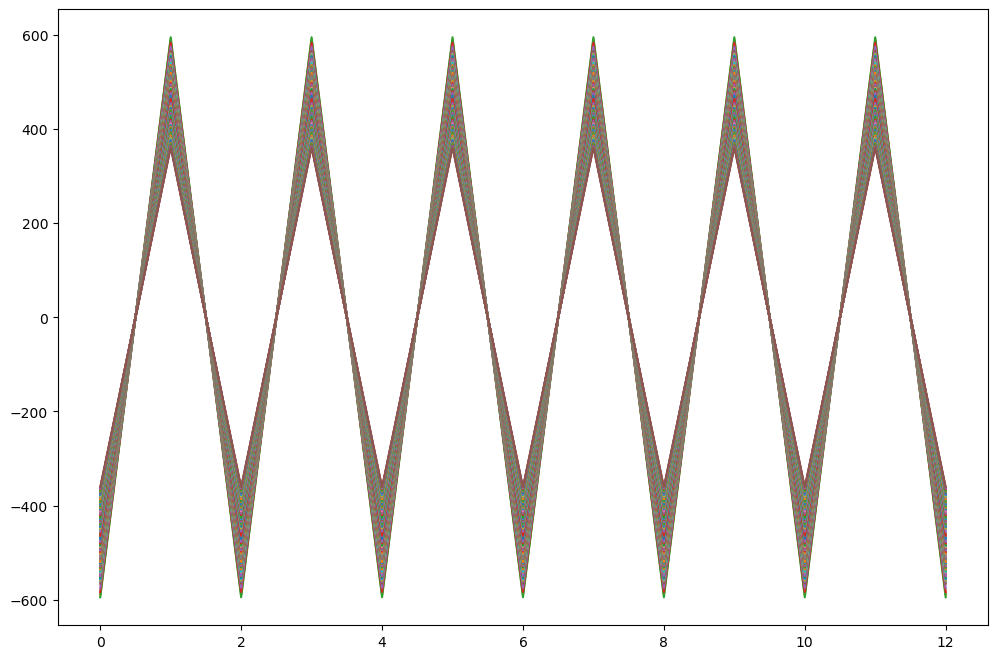

In [46]:
samplerate, audio = load_signal("c-note.wav")
t  = np.linspace(0, len(audio)/samplerate)
# plt.plot(audio)
# plt.show()
frame_length = 0.025
frame_step = 0.01
numbers_filters = 40
fft_coeff = 512
mels_coeff = 13
pre = pre_emphasis(audio)
frame_audio = audio_frames(pre, samplerate, frame_length, frame_step)
window = window(frame_audio, frame_length * samplerate)
stft_ps = stft_power_spec(window, frame_length * samplerate, fft_coeff) 
#power_spectrum = (stft, frame_length*samplerate)
mel_transform = h_mel_transform_filters(samplerate, numbers_filters)
mel_frequency_convert = mel_frequency_convert(mel_transform)
mel_filterbanks = mel_filterbanks(numbers_filters, mel_frequency_convert, stft_ps, samplerate, fft_coeff)
logairtm_filt = loagirtm_filt(mel_filterbanks ,stft_ps)
mels_dct = mels(logairtm_filt, mels_coeff)
mf = compute_mfcc(logairtm_filt)
plt.figure(figsize = (12,8))
plt.plot(mels_dct)
plt.show()

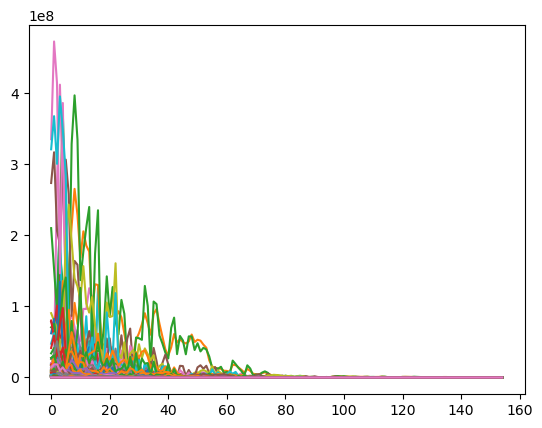

In [28]:
plt.plot(stft_power_spec)
plt.show()